In [1]:

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
import numpy as np
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

# 1. Load Dataset

In [5]:
traffic = pd.read_csv('traffic.csv', index_col=None,parse_dates=True)

In [6]:
traffic.head()

,Unnamed: 0,startDatetime,siteRef,direction,count,X,Y,OBJECTID,lane,type,...,Cloud Cover,Sea Level Pressure,Conditions,Hol_type,day,time,month,hour,dayOfweek,year
0,0,2018-01-01 00:00:00,1610011,1.0,1221.0,174.654029,-36.858365,6053,Inc,Continuous,...,83.2,1010.8,"Rain, Overcast",PublicHoliday,1,00:00:00,1,0,0,2018
1,1,2018-01-01 01:00:00,1610011,1.0,1148.0,174.654029,-36.858365,6053,Inc,Continuous,...,83.2,1010.8,"Rain, Overcast",PublicHoliday,1,01:00:00,1,1,0,2018
2,2,2018-01-01 02:00:00,1610011,1.0,636.0,174.654029,-36.858365,6053,Inc,Continuous,...,83.2,1010.8,"Rain, Overcast",PublicHoliday,1,02:00:00,1,2,0,2018
3,3,2018-01-01 03:00:00,1610011,1.0,406.0,174.654029,-36.858365,6053,Inc,Continuous,...,83.2,1010.8,"Rain, Overcast",PublicHoliday,1,03:00:00,1,3,0,2018
4,4,2018-01-01 04:00:00,1610011,1.0,295.0,174.654029,-36.858365,6053,Inc,Continuous,...,83.2,1010.8,"Rain, Overcast",PublicHoliday,1,04:00:00,1,4,0,2018


In [7]:
lincolnRd = traffic[traffic['siteRef'] == 1610013].copy()

# 2. Preprocessing

In [8]:
lincolnRd['startDatetime']=pd.to_datetime(lincolnRd['startDatetime'])

lincolnRd['date']=pd.to_datetime(lincolnRd['date'])

lincolnRd['time'] = pd.to_datetime(lincolnRd['time'])

In [9]:
lincolnRd= lincolnRd.drop(['Unnamed: 0'],axis=1)

In [10]:
lincolnRd.columns

Index(['startDatetime', 'siteRef', 'direction', 'count', 'X', 'Y', 'OBJECTID',
       'lane', 'type', 'percentHeavy', 'description', 'acceptedDays',
       'AADT5yearsAgo', 'AADT4yearsAgo', 'AADT3yearsAgo', 'AADT2yearsAgo',
       'AADT1yearAgo', 'siteType', 'date', 'Date time', 'Minimum Temperature',
       'Maximum Temperature', 'Temperature', 'Dew Point', 'Relative Humidity',
       'Wind Speed', 'Precipitation', 'Precipitation Cover', 'Visibility',
       'Cloud Cover', 'Sea Level Pressure', 'Conditions', 'Hol_type', 'day',
       'time', 'month', 'hour', 'dayOfweek', 'year'],
      dtype='object')

In [11]:
lincolnRd = lincolnRd.set_index('startDatetime')

<AxesSubplot:>

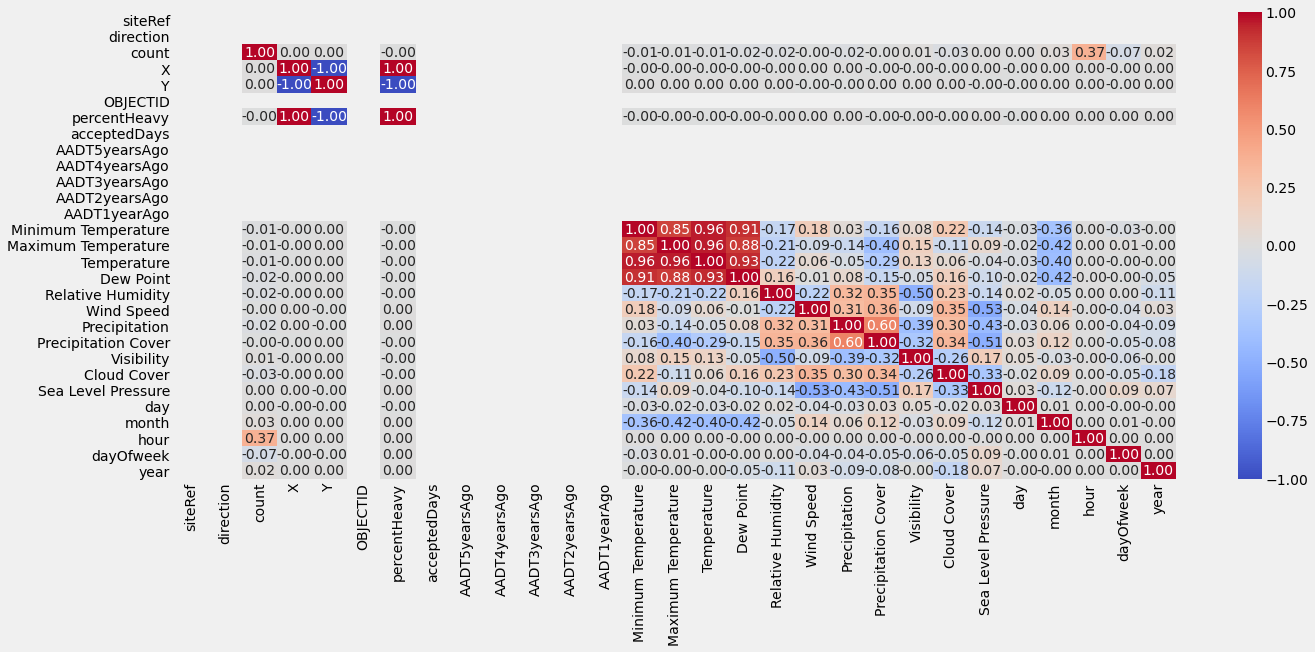

In [12]:
# Calculate correlation matrix
corr_matrix = lincolnRd.corr()


# Create heatmap
fig, ax = plt.subplots(figsize=(20, 8)) # Set the figure size
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# 3. Vis

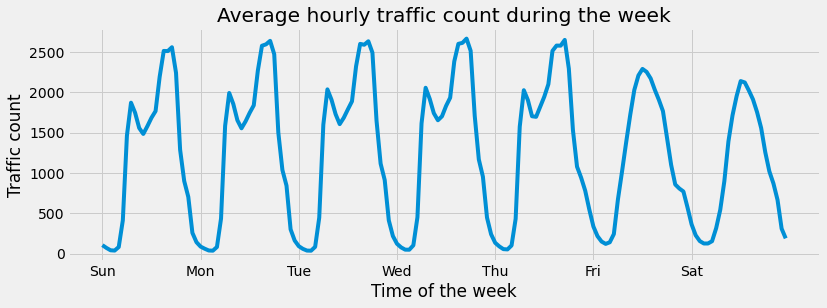

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
average_weekly_count = lincolnRd.groupby(["dayOfweek", "hour"])["count"].mean()
average_weekly_count.plot(ax=ax)
_ = ax.set(
    title="Average hourly traffic count during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Traffic count",
)

# 4. Setting Target and Features

In [14]:
feature_columns = ['siteRef','AADT5yearsAgo', 'AADT4yearsAgo', 'AADT3yearsAgo', 'AADT2yearsAgo',
       'AADT1yearAgo','Hol_type','day','month', 'hour','dayOfweek', 'Conditions', 'lane','Maximum Temperature']

target_variable = 'count'

In [15]:
# Convert Conditions to an ordered categorical variable
lincolnRd['Conditions'] = pd.Categorical(lincolnRd['Conditions'], categories=[ 'Clear','Partially cloudy','Rain, Partially cloudy','Rain', 'Rain, Overcast','Overcast'], ordered=True)


In [16]:
lincolnRd['Hol_type'] = pd.Categorical(lincolnRd['Hol_type'],categories=['PublicHoliday', 'SchoolHoliday', 'Weekend', 'SchoolDay'],ordered=True)

In [17]:
lincolnRd['lane']=pd.Categorical(lincolnRd['lane'],categories=['Inc','Ramp','Dec'],ordered=True)

In [18]:
X= lincolnRd[feature_columns]
y = lincolnRd[target_variable]

In [19]:
X.head()

,siteRef,AADT5yearsAgo,AADT4yearsAgo,AADT3yearsAgo,AADT2yearsAgo,AADT1yearAgo,Hol_type,day,month,hour,dayOfweek,Conditions,lane,Maximum Temperature
startDatetime,,,,,,,,,,,,,,
2018-01-01 00:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,0,0,"Rain, Overcast",Inc,24.1
2018-01-01 01:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,1,0,"Rain, Overcast",Inc,24.1
2018-01-01 02:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,2,0,"Rain, Overcast",Inc,24.1
2018-01-01 03:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,3,0,"Rain, Overcast",Inc,24.1
2018-01-01 04:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,4,0,"Rain, Overcast",Inc,24.1


In [20]:
X.columns

Index(['siteRef', 'AADT5yearsAgo', 'AADT4yearsAgo', 'AADT3yearsAgo',
       'AADT2yearsAgo', 'AADT1yearAgo', 'Hol_type', 'day', 'month', 'hour',
       'dayOfweek', 'Conditions', 'lane', 'Maximum Temperature'],
      dtype='object')

# 4. Time based cross-validation

In [21]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [22]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [23]:
train_1,test_1 = all_splits[1]
train_2,test_2 = all_splits[2]
train_3,test_3= all_splits[3]

In [24]:
X['lane'].unique()

['Inc']
Categories (1, object): ['Inc']

In [25]:
X.iloc[train_0]

,siteRef,AADT5yearsAgo,AADT4yearsAgo,AADT3yearsAgo,AADT2yearsAgo,AADT1yearAgo,Hol_type,day,month,hour,dayOfweek,Conditions,lane,Maximum Temperature
startDatetime,,,,,,,,,,,,,,
2018-04-14 00:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,Weekend,14,4,0,5,"Rain, Overcast",Inc,21.0
2018-04-14 01:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,Weekend,14,4,1,5,"Rain, Overcast",Inc,21.0
2018-04-14 02:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,Weekend,14,4,2,5,"Rain, Overcast",Inc,21.0
2018-04-14 03:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,Weekend,14,4,3,5,"Rain, Overcast",Inc,21.0
2018-04-14 04:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,Weekend,14,4,4,5,"Rain, Overcast",Inc,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-04 11:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,4,6,11,1,Overcast,Inc,15.5
2019-06-04 12:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,4,6,12,1,Overcast,Inc,15.5
2019-06-04 13:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,4,6,13,1,Overcast,Inc,15.5


In [26]:
train_4, test_4 = all_splits[4]

In [27]:
X.iloc[test_4]

,siteRef,AADT5yearsAgo,AADT4yearsAgo,AADT3yearsAgo,AADT2yearsAgo,AADT1yearAgo,Hol_type,day,month,hour,dayOfweek,Conditions,lane,Maximum Temperature
startDatetime,,,,,,,,,,,,,,
2019-11-20 08:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,20,11,8,2,Partially cloudy,Inc,20.0
2019-11-20 09:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,20,11,9,2,Partially cloudy,Inc,20.0
2019-11-20 10:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,20,11,10,2,Partially cloudy,Inc,20.0
2019-11-20 11:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,20,11,11,2,Partially cloudy,Inc,20.0
2019-11-20 12:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,20,11,12,2,Partially cloudy,Inc,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolHoliday,31,12,19,1,Partially cloudy,Inc,23.0
2019-12-31 20:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolHoliday,31,12,20,1,Partially cloudy,Inc,23.0
2019-12-31 21:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolHoliday,31,12,21,1,Partially cloudy,Inc,23.0


In [28]:
X.iloc[train_4]

,siteRef,AADT5yearsAgo,AADT4yearsAgo,AADT3yearsAgo,AADT2yearsAgo,AADT1yearAgo,Hol_type,day,month,hour,dayOfweek,Conditions,lane,Maximum Temperature
startDatetime,,,,,,,,,,,,,,
2018-09-27 16:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,27,9,16,3,"Rain, Partially cloudy",Inc,15.0
2018-09-27 17:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,27,9,17,3,"Rain, Partially cloudy",Inc,15.0
2018-09-27 18:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,27,9,18,3,"Rain, Partially cloudy",Inc,15.0
2018-09-27 19:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,27,9,19,3,"Rain, Partially cloudy",Inc,15.0
2018-09-27 20:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,27,9,20,3,"Rain, Partially cloudy",Inc,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-18 03:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,18,11,3,0,"Rain, Overcast",Inc,19.9
2019-11-18 04:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,18,11,4,0,"Rain, Overcast",Inc,19.9
2019-11-18 05:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,SchoolDay,18,11,5,0,"Rain, Overcast",Inc,19.9


In [29]:
categorical_columns = [
    
    'Conditions',
    'lane',
    "Hol_type",
]

categories = [
    traffic[column].unique() for column in categorical_columns
]

ordinal_encoder = OrdinalEncoder(categories=categories)


In [30]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


In [31]:
X.head()

,siteRef,AADT5yearsAgo,AADT4yearsAgo,AADT3yearsAgo,AADT2yearsAgo,AADT1yearAgo,Hol_type,day,month,hour,dayOfweek,Conditions,lane,Maximum Temperature
startDatetime,,,,,,,,,,,,,,
2018-01-01 00:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,0,0,"Rain, Overcast",Inc,24.1
2018-01-01 01:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,1,0,"Rain, Overcast",Inc,24.1
2018-01-01 02:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,2,0,"Rain, Overcast",Inc,24.1
2018-01-01 03:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,3,0,"Rain, Overcast",Inc,24.1
2018-01-01 04:00:00,1610013,26815.0,29625.0,30355.0,29927.0,31569.0,PublicHoliday,1,1,4,0,"Rain, Overcast",Inc,24.1


In [32]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)

In [33]:


naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    KNeighborsRegressor(n_neighbors=5),
)


evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     194.905 +/- 13.173
Root Mean Squared Error: 266.748 +/- 20.005


In [34]:
one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "dayOfweek", "month"]),
        ],
        remainder=MinMaxScaler(),
    ),
    KNeighborsRegressor(n_neighbors=5),
)

evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     258.053 +/- 40.025
Root Mean Squared Error: 455.133 +/- 47.994


In [35]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [36]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["dayOfweek"]),
        ("weekday_cos", cos_transformer(7), ["dayOfweek"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    KNeighborsRegressor(n_neighbors=5),
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     153.110 +/- 19.199
Root Mean Squared Error: 214.183 +/- 24.459


In [37]:
from sklearn.preprocessing import SplineTransformer

In [38]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [39]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["dayOfweek"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    KNeighborsRegressor(n_neighbors=5),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     129.295 +/- 19.865
Root Mean Squared Error: 183.297 +/- 30.242


In [40]:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_pipeline_predictions = naive_linear_pipeline.predict(X.iloc[test_2])

one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_2])

cyclic_cossin_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_2])

cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_2])

In [50]:
# Get the actual test targets for the corresponding test set
y_test = y.iloc[test_2]

# Calculate the performance metrics for each pipeline
naive_linear_mape = mean_absolute_percentage_error(y_test, naive_linear_pipeline_predictions)
naive_linear_nrmse = np.sqrt(mean_squared_error(y_test, naive_linear_pipeline_predictions)) / np.mean(y_test)
r2_naive_linear = r2_score(y_test, naive_linear_pipeline_predictions)

one_hot_linear_mape = mean_absolute_percentage_error(y_test, one_hot_linear_predictions)
one_hot_linear_nrmse = np.sqrt(mean_squared_error(y_test, one_hot_linear_predictions)) / np.mean(y_test)
r2_one_hot_linear = r2_score(y_test, one_hot_linear_predictions)
one_hot_linear_mae = mean_absolute_error(y_test, one_hot_linear_predictions)
one_hot_linear_mse = mean_squared_error(y_test, one_hot_linear_predictions)

cyclic_cossin_linear_mape = mean_absolute_percentage_error(y_test, cyclic_cossin_linear_predictions)
cyclic_cossin_linear_nrmse = np.sqrt(mean_squared_error(y_test, cyclic_cossin_linear_predictions)) / np.mean(y_test)
r2_cyclic_cossin_linear= r2_score(y_test, cyclic_cossin_linear_predictions)
cyclic_cossin_linear_mae = mean_absolute_error(y_test, cyclic_cossin_linear_predictions)
cyclic_cossin_linear_mse = mean_squared_error(y_test, cyclic_cossin_linear_predictions)

cyclic_spline_linear_mape = mean_absolute_percentage_error(y_test, cyclic_spline_linear_predictions)
cyclic_spline_linear_nrmse = np.sqrt(mean_squared_error(y_test, cyclic_spline_linear_predictions)) / np.mean(y_test)
r2_cyclic_spline_linear = r2_score(y_test, cyclic_spline_linear_predictions)
cyclic_spline_linear_mae = mean_absolute_error(y_test, cyclic_spline_linear_predictions)
cyclic_spline_linear_mse = mean_squared_error(y_test, cyclic_spline_linear_predictions)

# Print the metrics for each pipeline
print(f"Naive Linear MAPE:         {naive_linear_mape:.3f}")
print(f"Naive Linear NRMSE:        {naive_linear_nrmse:.3f}")
print(f"Naive Linear R2:        {r2_naive_linear:.3f}")

print(f"Cyclic Spline Linear MAPE: {cyclic_spline_linear_mape:.3f}")
print(f"Cyclic Spline Linear NRMSE:{cyclic_spline_linear_nrmse:.3f}")
print(f"Cyclic Spline Linear R2:{r2_cyclic_spline_linear:.3f}")
print(f"Cyclic Spline Linear MSE:{cyclic_spline_linear_mse:.3f}")

print(f"Cyclic Cosine Linear MAPE: {cyclic_cossin_linear_mape:.3f}")
print(f"Cyclic Cosine Linear NRMSE:{cyclic_cossin_linear_nrmse:.3f}")
print(f"Cyclic Cosine Linear R2:{r2_cyclic_cossin_linear:.3f}")
print(f"Cyclic Cosine Linear MSE:{cyclic_cossin_linear_mse:.3f}")


print(f"One-Hot Linear MAPE:       {one_hot_linear_mape:.3f}")
print(f"One-Hot Linear NRMSE:      {one_hot_linear_nrmse:.3f}")
print(f"One-Hot Linear R2:      {r2_one_hot_linear:.3f}")
print(f"One-Hot Linear MSE:      {one_hot_linear_mse:.3f}")

Naive Linear MAPE:         96969705736690576.000
Naive Linear NRMSE:        0.216
Naive Linear R2:        0.914
Cyclic Spline Linear MAPE: 63555698661377928.000
Cyclic Spline Linear NRMSE:0.147
Cyclic Spline Linear R2:0.961
Cyclic Spline Linear MSE:34233.313
Cyclic Cosine Linear MAPE: 71403671372033744.000
Cyclic Cosine Linear NRMSE:0.167
Cyclic Cosine Linear R2:0.949
Cyclic Cosine Linear MSE:44627.473
One-Hot Linear MAPE:       48966738028473936.000
One-Hot Linear NRMSE:      0.361
One-Hot Linear R2:      0.762
One-Hot Linear MSE:      207681.746


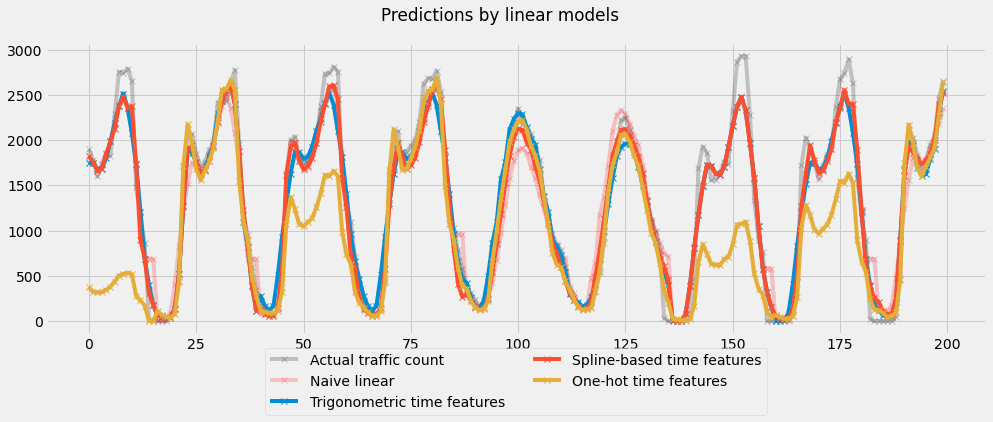

In [42]:
last_hours = slice(-200, None)
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_2].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic count",
    color="black",
)
ax.plot(
    naive_linear_pipeline_predictions[last_hours],
    "x-",
    alpha=0.2,
    label="Naive linear",
    color="red",
)
ax.plot(
    cyclic_cossin_linear_predictions[last_hours],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_hours],
    "x-",
    label="Spline-based time features",
)
ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features",
)
_ = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)

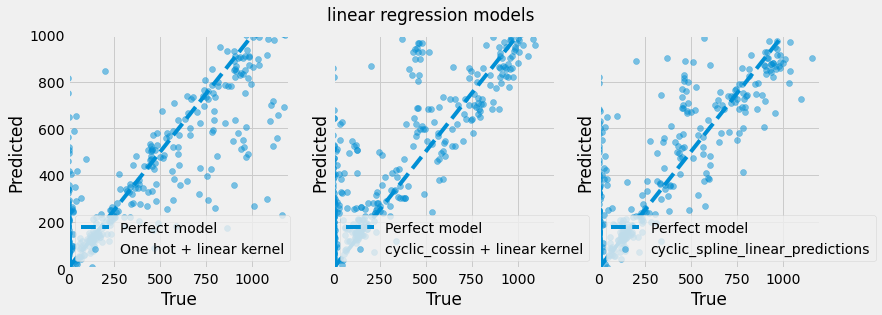

In [43]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("linear regression models")
predictions = [
    one_hot_linear_predictions,
    cyclic_cossin_linear_predictions,cyclic_spline_linear_predictions]
labels = [
    "One hot + linear kernel",
    "cyclic_cossin + linear kernel","cyclic_spline_linear_predictions"
    ]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_2].values, pred, alpha=0.5, label=label)
    ax.plot([0, 1200], [0, 1200], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1200),
        ylim=(0, 1000),
        xlabel="True",
        ylabel="Predicted",
    )
    ax.legend(loc='lower left')

plt.show()

In [44]:
from sklearn.kernel_approximation import Nystroem


cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    KNeighborsRegressor(n_neighbors=5),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     128.386 +/- 19.741
Root Mean Squared Error: 182.800 +/- 30.357


In [45]:
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "dayOfweek", "month"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    KNeighborsRegressor(n_neighbors=5),
)
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     474.214 +/- 43.042
Root Mean Squared Error: 619.155 +/- 33.747


In [46]:
one_hot_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[test_2])

cyclic_spline_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_2])

In [52]:
# MAPE function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Get predictions
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[test_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_0])

# Calculate MAE, RMSE, MAPE, and NRMSE
mae_one_hot_poly = mean_absolute_error(y.iloc[test_0], one_hot_poly_predictions)
mse_one_hot_poly = mean_squared_error(y.iloc[test_0], one_hot_poly_predictions)
mape_one_hot_poly = mape(y.iloc[test_0], one_hot_poly_predictions)
#nrmse_one_hot_poly = rmse_one_hot_poly / y.iloc[test_0].mean()
r2_one_hot_poly = r2_score(y.iloc[test_0], one_hot_poly_predictions)

mae_cyclic_spline_poly = mean_absolute_error(y.iloc[test_0], cyclic_spline_poly_predictions)
mse_cyclic_spline_poly = mean_squared_error(y.iloc[test_0], cyclic_spline_poly_predictions)
mape_cyclic_spline_poly = mape(y.iloc[test_0], cyclic_spline_poly_predictions)
#nrmse_cyclic_spline_poly = rmse_cyclic_spline_poly / y.iloc[test_0].mean()
r2_cyclic_spline_poly = r2_score(y.iloc[test_0], cyclic_spline_poly_predictions)

# Print results
print("Results for One Hot Poly Pipeline:")
print(f"MAE: {mae_one_hot_poly:.3f}")
print(f"RMSE: {mse_one_hot_poly:.3f}")
print(f"MAPE: {mape_one_hot_poly:.3f}")
#print(f"NRMSE: {nrmse_one_hot_poly:.3f}")
print(f"R2: {r2_one_hot_poly:.3f}")

print("\nResults for Cyclic Spline Poly Pipeline:")
print(f"MAE: {mae_cyclic_spline_poly:.3f}")
print(f"RMSE: {mse_cyclic_spline_poly:.3f}")
print(f"MAPE: {mape_cyclic_spline_poly:.3f}")
#print(f"NRMSE: {nrmse_cyclic_spline_poly:.3f}")
print(f"R2: {r2_cyclic_spline_poly:.3f}")

Results for One Hot Poly Pipeline:
MAE: 482.546
RMSE: 404723.130
MAPE: inf
R2: 0.515

Results for Cyclic Spline Poly Pipeline:
MAE: 115.048
RMSE: 27376.590
MAPE: inf
R2: 0.967


In [ ]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic count",
    color="black",
)

ax.plot(
    one_hot_poly_predictions[last_hours],
    "x-",
    label="One-hot + polynomial kernel",
)
ax.plot(
    cyclic_spline_poly_predictions[last_hours],
    "x-",
    label="Splines + polynomial kernel",
)
_ = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    one_hot_poly_predictions,
    cyclic_spline_poly_predictions]
labels = [
    "One hot + polynomial kernel",
    "Splines + polynomial kernel"
    ]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.5, label=label)
    ax.plot([0, 1200], [0, 1200], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1200),
        ylim=(0, 1000),
        xlabel="True",
        ylabel="Predicted",
    )
    ax.legend()


plt.show()

In [ ]:

predictions_chosen_model = cyclic_spline_poly_pipeline.predict(X.iloc[test_2])

In [ ]:
len(predictions_chosen_model)

In [ ]:
decision_making_df = pd.DataFrame()

In [ ]:
decision_making_df['predictions'] = predictions_chosen_model

In [ ]:
decision_making_df['actual']= y.iloc[test_2].values

In [ ]:
decision_making_df.reset_index()


In [ ]:
test_features = pd.DataFrame(X.iloc[test_2])

In [ ]:
# reset indexes for both dataframes
test_features = test_features.reset_index(drop=True)
decision_making_df = decision_making_df.reset_index(drop=True)

In [ ]:
# concatenate dataframes horizontally
df_concat = pd.concat([test_features, decision_making_df], axis=1)

In [ ]:
df_concat

In [ ]:
df_concat.to_csv('decision_df.csv',index=False)